## __1. Extracting Historic weather data from API URL__

#### 1.1 Daily weather data extraction (Containing sunrise and sunset daily data)

In [4]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Fetch data from the API
url = "https://archive-api.open-meteo.com/v1/archive?latitude=51.4552&longitude=-2.5966&start_date=2018-01-01&end_date=2023-06-06&daily=sunrise,sunset&timezone=Europe%2FLondon"
response = requests.get(url)
data = response.json()

# Extract the required data from the JSON
dates = data["daily"]["time"]
sunrises = data["daily"]["sunrise"]
sunsets = data["daily"]["sunset"]

# Create the DataFrame
weather_data_daily = pd.DataFrame({"Date": dates, "Sunrise": sunrises, "Sunset": sunsets})

# Print the DataFrame
weather_data_daily

,Date,Sunrise,Sunset
0,2018-01-01,2018-01-01T09:15,2018-01-01T17:12
1,2018-01-02,2018-01-02T09:15,2018-01-02T17:13
2,2018-01-03,2018-01-03T09:15,2018-01-03T17:14
3,2018-01-04,2018-01-04T09:15,2018-01-04T17:15
4,2018-01-05,2018-01-05T09:14,2018-01-05T17:16
...,...,...,...
1978,2023-06-02,2023-06-02T04:58,2023-06-02T21:18
1979,2023-06-03,2023-06-03T04:57,2023-06-03T21:19
1980,2023-06-04,2023-06-04T04:57,2023-06-04T21:20
1981,2023-06-05,2023-06-05T04:56,2023-06-05T21:21


#### 1.2 Hourly weather data extraction (Containing temperature, humidity and shortwave_radiation hourly data)

In [6]:
# Fetch data from the API
url = "https://archive-api.open-meteo.com/v1/archive?latitude=51.4552&longitude=-2.5966&start_date=2018-01-01&end_date=2023-06-06&hourly=temperature_2m,relativehumidity_2m,shortwave_radiation&timezone=Europe%2FLondon"
response = requests.get(url)
data = response.json()

# Extract relevant data from the response
hourly_data = data["hourly"]
column_names = ["time", "temperature_2m", "relativehumidity_2m", "shortwave_radiation"]

# Create the DataFrame
weather_data_hourly = pd.DataFrame(hourly_data, columns=column_names)

# Print the DataFrame
weather_data_hourly

,time,temperature_2m,relativehumidity_2m,shortwave_radiation
0,2018-01-01T00:00,6.1,82,0.0
1,2018-01-01T01:00,5.7,84,0.0
2,2018-01-01T02:00,5.5,85,0.0
3,2018-01-01T03:00,5.7,87,0.0
4,2018-01-01T04:00,6.2,85,0.0
...,...,...,...,...
47587,2023-06-06T19:00,17.2,55,320.0
47588,2023-06-06T20:00,14.7,64,147.0
47589,2023-06-06T21:00,13.8,68,52.0
47590,2023-06-06T22:00,13.3,70,1.0


## __2. Historic weather data Cleaning and Analysis__

In [7]:
# Rename the columns in weather_data_hourly
weather_data_hourly = weather_data_hourly.rename(columns={'temperature_2m': 'Temperature', 'relativehumidity_2m': 'Humidity', "shortwave_radiation": "Shortwave_Radiation"})

In [8]:
# Convert 'time' column in hourly dataset to datetime
weather_data_hourly['time'] = pd.to_datetime(weather_data_hourly['time'])
weather_data_daily['Date'] = pd.to_datetime(weather_data_daily['Date'])

#### 2.1 Converting the Hourly weather data into Daily weather data calculating the mean of the variables and merged it

In [9]:
# Group hourly data by date and calculate mean
hourly_data_mean = weather_data_hourly.groupby(weather_data_hourly['time'].dt.date).mean()

# Reset index to make date a column
hourly_data_mean = hourly_data_mean.reset_index()

# Convert 'Date' column in daily data to datetime
weather_data_daily['Date'] = pd.to_datetime(weather_data_daily['Date'])

# Merge hourly mean data with daily data based on date
merged_historic_weather_data = weather_data_daily.merge(hourly_data_mean, left_on=weather_data_daily['Date'].dt.date, right_on=hourly_data_mean['time'], how='left')

# Drop unnecessary columns from the merged data
merged_historic_weather_data.drop(['key_0', 'time'], axis=1, inplace=True)

# Calculate hours of sunlight per day
merged_historic_weather_data['Sunrise'] = pd.to_datetime(merged_historic_weather_data['Sunrise'])
merged_historic_weather_data['Sunset'] = pd.to_datetime(merged_historic_weather_data['Sunset'])
merged_historic_weather_data['Sunlight_hours'] = (merged_historic_weather_data['Sunset'] - merged_historic_weather_data['Sunrise']).dt.total_seconds() / 3600

# Print the merged data
merged_historic_weather_data

,Date,Sunrise,Sunset,Temperature,Humidity,Shortwave_Radiation,Sunlight_hours
0,2018-01-01,2018-01-01 09:15:00,2018-01-01 17:12:00,6.383333,81.708333,30.333333,7.950000
1,2018-01-02,2018-01-02 09:15:00,2018-01-02 17:13:00,7.375000,86.500000,8.916667,7.966667
2,2018-01-03,2018-01-03 09:15:00,2018-01-03 17:14:00,8.233333,70.750000,40.958333,7.983333
3,2018-01-04,2018-01-04 09:15:00,2018-01-04 17:15:00,8.004167,82.500000,25.000000,8.000000
4,2018-01-05,2018-01-05 09:14:00,2018-01-05 17:16:00,5.279167,88.250000,36.083333,8.033333
...,...,...,...,...,...,...,...
1978,2023-06-02,2023-06-02 04:58:00,2023-06-02 21:18:00,13.195833,65.375000,301.166667,16.333333
1979,2023-06-03,2023-06-03 04:57:00,2023-06-03 21:19:00,14.091667,68.791667,323.791667,16.366667
1980,2023-06-04,2023-06-04 04:57:00,2023-06-04 21:20:00,15.275000,66.083333,342.250000,16.383333
1981,2023-06-05,2023-06-05 04:56:00,2023-06-05 21:21:00,13.758333,70.375000,333.000000,16.416667


In [10]:
# From all the variables of the historic weather data, the most important ones were selected
selected_columns = ["Temperature", "Humidity", "Shortwave_Radiation", "Date", "Sunlight_hours"]
historic_weather_data = merged_historic_weather_data[selected_columns]

In [11]:
historic_weather_data

,Temperature,Humidity,Shortwave_Radiation,Date,Sunlight_hours
0,6.383333,81.708333,30.333333,2018-01-01,7.950000
1,7.375000,86.500000,8.916667,2018-01-02,7.966667
2,8.233333,70.750000,40.958333,2018-01-03,7.983333
3,8.004167,82.500000,25.000000,2018-01-04,8.000000
4,5.279167,88.250000,36.083333,2018-01-05,8.033333
...,...,...,...,...,...
1978,13.195833,65.375000,301.166667,2023-06-02,16.333333
1979,14.091667,68.791667,323.791667,2023-06-03,16.366667
1980,15.275000,66.083333,342.250000,2023-06-04,16.383333
1981,13.758333,70.375000,333.000000,2023-06-05,16.416667


## __3. Extracting the Solar Generation Data__

In [12]:
# Historic solar consumption data from 2018-01-01 to 2023-06-06
solar_df1 = pd.read_csv("Full(1).csv")

In [13]:
solar_df1["Time"] = pd.to_datetime(solar_df1["Time"])

## __4. Merge the weather and solar datasets__

In [14]:
# Merged the historic weather data with the solar generation consumption data
merged_historic_solar_weather_df = pd.merge(historic_weather_data, solar_df1, left_on='Date', right_on='Time')

In [15]:
# Convert "Temperature" and "Humidity" to integers
merged_historic_solar_weather_df["Temperature"] = merged_historic_solar_weather_df["Temperature"].astype(int)
merged_historic_solar_weather_df["Humidity"] = merged_historic_solar_weather_df["Humidity"].astype(int)

# Convert "Shortwave_Radiation" and "Sunlight_hours" to floats with two decimal places
merged_historic_solar_weather_df["Shortwave_Radiation"] = merged_historic_solar_weather_df["Shortwave_Radiation"].round(2)
merged_historic_solar_weather_df["Sunlight_hours"] = merged_historic_solar_weather_df["Sunlight_hours"].round(2)

In [16]:
merged_historic_solar_weather_df

,Temperature,Humidity,Shortwave_Radiation,Date,Sunlight_hours,Time,gen
0,6,81,30.33,2018-01-01,7.95,2018-01-01,23.362676
1,7,86,8.92,2018-01-02,7.97,2018-01-02,18.812548
2,8,70,40.96,2018-01-03,7.98,2018-01-03,29.057803
3,8,82,25.00,2018-01-04,8.00,2018-01-04,22.020129
4,5,88,36.08,2018-01-05,8.03,2018-01-05,29.631941
...,...,...,...,...,...,...,...
1978,13,65,301.17,2023-06-02,16.33,2023-06-02,97.246218
1979,14,68,323.79,2023-06-03,16.37,2023-06-03,121.742163
1980,15,66,342.25,2023-06-04,16.38,2023-06-04,120.950493
1981,13,70,333.00,2023-06-05,16.42,2023-06-05,68.336305


## __5. Calculate the correlations__

In [17]:
# Calculate the correlation matrix
correlation_matrix = merged_historic_solar_weather_df.corr()
# Print the correlation matrix
print(correlation_matrix)

                     Temperature  Humidity  Shortwave_Radiation  \
Temperature             1.000000 -0.407553             0.576301   
Humidity               -0.407553  1.000000            -0.772725   
Shortwave_Radiation     0.576301 -0.772725             1.000000   
Sunlight_hours          0.697812 -0.595304             0.825120   
gen                     0.549054 -0.666227             0.841948   

                     Sunlight_hours       gen  
Temperature                0.697812  0.549054  
Humidity                  -0.595304 -0.666227  
Shortwave_Radiation        0.825120  0.841948  
Sunlight_hours             1.000000  0.788099  
gen                        0.788099  1.000000  


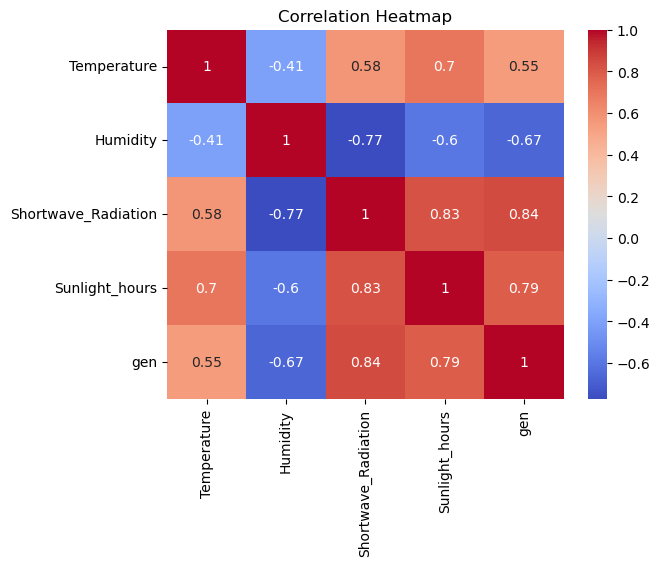

In [18]:
# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# Set the title of the plot
plt.title('Correlation Heatmap')
# Display the plot
plt.show()

#### 5.1 Statistical Analysis (p-value)

In [19]:
import scipy.stats as stats
# Calculate the Pearson correlation coefficient and the p-value for Shortwave_Radiation vs Gen
r, p = stats.pearsonr(merged_historic_solar_weather_df['gen'], merged_historic_solar_weather_df['Shortwave_Radiation'])
print('Analysis of Shortwave_Radiation vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))
print()
# Calculate the Pearson correlation coefficient and the p-value for Shortwave_Radiation vs Gen
r, p = stats.pearsonr(merged_historic_solar_weather_df['gen'], merged_historic_solar_weather_df['Sunlight_hours'])
print('Analysis of Sunlight_hours vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))
print()
# Calculate the Pearson correlation coefficient and the p-value for humidity vs Gen
r, p = stats.pearsonr(merged_historic_solar_weather_df['gen'], merged_historic_solar_weather_df['Humidity'])
print('Analysis of Humidity vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))
print()
# Calculate the Pearson correlation coefficient and the p-value for Temperature vs Gen
r, p = stats.pearsonr(merged_historic_solar_weather_df['gen'], merged_historic_solar_weather_df['Temperature'])
print('Analysis of Temperature vs Gen')
print('---------------------------------------------')
print('The Pearson correlation coefficient is:', round(r, 3))
print('The p-value is: {:.10f}'.format(p))

Analysis of Shortwave_Radiation vs Gen
---------------------------------------------
The Pearson correlation coefficient is: 0.842
The p-value is: 0.0000000000

Analysis of Sunlight_hours vs Gen
---------------------------------------------
The Pearson correlation coefficient is: 0.788
The p-value is: 0.0000000000

Analysis of Humidity vs Gen
---------------------------------------------
The Pearson correlation coefficient is: -0.666
The p-value is: 0.0000000000

Analysis of Temperature vs Gen
---------------------------------------------
The Pearson correlation coefficient is: 0.549
The p-value is: 0.0000000000


### __Interpretation__
1. Shortwave Radiation: There is a positive correlation of __0.84__ between shortwave radiation and solar panel generation. This correlation implies that as shortwave radiation increases, the generation of solar panels also tends to increase.

2. Sunlight Hours: There is a positive correlation of __0.79__ between sunlight hours and solar panel generation. This suggests that as the number of sunlight hours increases, the generation of solar panels tends to increase as well.

3. Humidity: There is a negative correlation of __-0.67__ between humidity and solar panel generation. This indicates that as humidity increases, the generation of solar panels tends to decrease.


4. Temperature: There is a positive correlation of __0.55__ between temperature and solar panel generation. This suggests that as temperature increases, the generation of solar panels also tends to increase.

## __6. Extracting Forecast weather data from API URL__

#### 6.1 Daily weather data extraction (Containing sunrise and sunset daily data)

In [20]:
# Fetch data from the API
url = "https://api.open-meteo.com/v1/forecast?latitude=51.4552&longitude=-2.5966&daily=sunrise,sunset&timezone=Europe%2FLondon&forecast_days=14"
response = requests.get(url)
data = response.json()

# Extract the required data from the JSON
dates = data["daily"]["time"]
sunrises = data["daily"]["sunrise"]
sunsets = data["daily"]["sunset"]

# Create the DataFrame
weather_forecast_daily = pd.DataFrame({"Date": dates, "Sunrise": sunrises, "Sunset": sunsets})

# Print the DataFrame
weather_forecast_daily

,Date,Sunrise,Sunset
0,2023-07-11,2023-07-11T05:06,2023-07-11T21:25
1,2023-07-12,2023-07-12T05:07,2023-07-12T21:24
2,2023-07-13,2023-07-13T05:08,2023-07-13T21:23
3,2023-07-14,2023-07-14T05:09,2023-07-14T21:22
4,2023-07-15,2023-07-15T05:11,2023-07-15T21:21
5,2023-07-16,2023-07-16T05:12,2023-07-16T21:20
6,2023-07-17,2023-07-17T05:13,2023-07-17T21:19
7,2023-07-18,2023-07-18T05:14,2023-07-18T21:18
8,2023-07-19,2023-07-19T05:15,2023-07-19T21:17
9,2023-07-20,2023-07-20T05:17,2023-07-20T21:16


#### 6.2 Hourly weather data extraction (Containing temperature, humidity and shortwave_radiation hourly data)

In [21]:
# Fetch data from the API
url = "https://api.open-meteo.com/v1/forecast?latitude=51.4552&longitude=-2.5966&hourly=temperature_2m,relativehumidity_2m,shortwave_radiation&forecast_days=14"
response = requests.get(url)
data = response.json()

# Extract relevant data from the response
hourly_data = data["hourly"]
column_names = ["time", "temperature_2m", "relativehumidity_2m", "shortwave_radiation"]

# Create the DataFrame
weather_forecast_hourly = pd.DataFrame(hourly_data, columns=column_names)

# Print the DataFrame
weather_forecast_hourly

,time,temperature_2m,relativehumidity_2m,shortwave_radiation
0,2023-07-11T00:00,18.0,90,0.0
1,2023-07-11T01:00,18.4,85,0.0
2,2023-07-11T02:00,17.2,83,0.0
3,2023-07-11T03:00,16.3,82,0.0
4,2023-07-11T04:00,15.7,83,0.0
...,...,...,...,...
331,2023-07-24T19:00,18.1,68,108.0
332,2023-07-24T20:00,16.7,76,42.0
333,2023-07-24T21:00,15.6,82,0.0
334,2023-07-24T22:00,15.6,83,0.0


#### 6.3 Forecast Weather data cleaning

In [22]:
# Rename the columns in weather_data_hourly
weather_forecast_hourly = weather_forecast_hourly.rename(columns={'temperature_2m': 'Temperature', 'relativehumidity_2m': 'Humidity', "shortwave_radiation": "Shortwave_Radiation"})

In [23]:
# Convert 'time' column in hourly dataset to datetime
weather_forecast_hourly['time'] = pd.to_datetime(weather_forecast_hourly['time'])
weather_forecast_daily['Date'] = pd.to_datetime(weather_forecast_daily['Date'])

#### 6.4 Converting the Hourly weather data into Daily weather data calculating the mean of the variables and merged it

In [24]:
# Group hourly data by date and calculate mean
hourly_data_mean = weather_forecast_hourly.groupby(weather_forecast_hourly['time'].dt.date).mean()

# Reset index to make date a column
hourly_data_mean = hourly_data_mean.reset_index()

# Convert 'Date' column in daily data to datetime
weather_forecast_daily['Date'] = pd.to_datetime(weather_forecast_daily['Date'])

# Merge hourly mean data with daily data based on date
merged_forecast_weather_data = weather_forecast_daily.merge(hourly_data_mean, left_on=weather_forecast_daily['Date'].dt.date, right_on=hourly_data_mean['time'], how='left')

# Drop unnecessary columns from the merged data
merged_forecast_weather_data.drop(['key_0', 'time'], axis=1, inplace=True)

# Calculate hours of sunlight per day
merged_forecast_weather_data['Sunrise'] = pd.to_datetime(merged_forecast_weather_data['Sunrise'])
merged_forecast_weather_data['Sunset'] = pd.to_datetime(merged_forecast_weather_data['Sunset'])
merged_forecast_weather_data['Sunlight_hours'] = (merged_forecast_weather_data['Sunset'] - merged_forecast_weather_data['Sunrise']).dt.total_seconds() / 3600

# Print the merged data
merged_forecast_weather_data

,Date,Sunrise,Sunset,Temperature,Humidity,Shortwave_Radiation,Sunlight_hours
0,2023-07-11,2023-07-11 05:06:00,2023-07-11 21:25:00,17.470833,77.125000,172.125000,16.316667
1,2023-07-12,2023-07-12 05:07:00,2023-07-12 21:24:00,16.762500,76.041667,274.541667,16.283333
2,2023-07-13,2023-07-13 05:08:00,2023-07-13 21:23:00,16.533333,76.375000,335.541667,16.250000
3,2023-07-14,2023-07-14 05:09:00,2023-07-14 21:22:00,15.450000,88.958333,64.291667,16.216667
4,2023-07-15,2023-07-15 05:11:00,2023-07-15 21:21:00,16.137500,80.000000,210.333333,16.166667
5,2023-07-16,2023-07-16 05:12:00,2023-07-16 21:20:00,16.862500,80.750000,198.916667,16.133333
6,2023-07-17,2023-07-17 05:13:00,2023-07-17 21:19:00,16.629167,76.500000,227.166667,16.100000
7,2023-07-18,2023-07-18 05:14:00,2023-07-18 21:18:00,16.483333,74.250000,303.750000,16.066667
8,2023-07-19,2023-07-19 05:15:00,2023-07-19 21:17:00,16.241667,69.541667,314.875000,16.033333
9,2023-07-20,2023-07-20 05:17:00,2023-07-20 21:16:00,16.937500,74.333333,252.625000,15.983333


In [25]:
# From all the variables of the historic weather data, the most important ones were selected
selected_columns = ["Temperature", "Humidity", "Shortwave_Radiation", "Date", "Sunlight_hours"]
forecast_weather_df = merged_forecast_weather_data[selected_columns]

In [26]:
forecast_weather_df

,Temperature,Humidity,Shortwave_Radiation,Date,Sunlight_hours
0,17.470833,77.125000,172.125000,2023-07-11,16.316667
1,16.762500,76.041667,274.541667,2023-07-12,16.283333
2,16.533333,76.375000,335.541667,2023-07-13,16.250000
3,15.450000,88.958333,64.291667,2023-07-14,16.216667
4,16.137500,80.000000,210.333333,2023-07-15,16.166667
5,16.862500,80.750000,198.916667,2023-07-16,16.133333
6,16.629167,76.500000,227.166667,2023-07-17,16.100000
7,16.483333,74.250000,303.750000,2023-07-18,16.066667
8,16.241667,69.541667,314.875000,2023-07-19,16.033333
9,16.937500,74.333333,252.625000,2023-07-20,15.983333


## __7. Solar Generation Prediction__

The following variables were examined for their correlation with solar generation (Gen):

| Variable              | Gen Correlation |
|-----------------------|-----------------|
| Temperature           | 0.549054        |
| Humidity              | -0.666227       |
| Shortwave Radiation   | 0.841948        |
| Sunlight Hours        | 0.788099        |

#### __7.1 Multicollinearity Check__

To ensure reliable model interpretation, I checked for multicollinearity using the Variance Inflation Factor (VIF) to identify highly correlated variables that might affect the stability of the regression model.

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame with the predictor variables
df = merged_historic_solar_weather_df[["Shortwave_Radiation", "Sunlight_hours", "Humidity", "Temperature"]]

# Calculate VIF for each predictor variable
vif = pd.DataFrame()
vif["Variable"] = df.columns
vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

vif

,Variable,VIF
0,Shortwave_Radiation,12.387690
1,Sunlight_hours,70.290040
2,Humidity,24.703963
3,Temperature,9.784695


#### __Interpreation__
The VIF values indicate the presence of multicollinearity (VIF value higher than 10) between the predictor variables in your regression model. 

#### __7.2 PCA__

#### To address multicollinearity, I applied PCA in the "merged_historic_solar_weather_df" (which has the historic weather and solar generation dataset) to transform the correlated variables into a smaller set of uncorrelated principal components, reducing dimensionality while retaining most of the variance in the data.

In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Create a DataFrame with the predictor variables
df = merged_historic_solar_weather_df[["Shortwave_Radiation", "Sunlight_hours", "Humidity", "Temperature"]]

# Standardize the variables
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Perform PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Determine the number of components to retain
num_components = np.argmax(cumulative_variance >= 0.95) + 1

# Retain the desired number of components
final_principal_components = principal_components[:, :num_components]

# Construct the DataFrame with the retained components
principal_df = pd.DataFrame(data=final_principal_components, columns=["PC{}".format(i) for i in range(1, num_components + 1)])

# Add the target variable to the principal components DataFrame, if applicable
principal_df["gen"] = merged_historic_solar_weather_df["gen"]

# Print the updated DataFrame
print(principal_df)

           PC1       PC2       PC3         gen
0    -1.746986  0.612923  0.704883   23.362676
1    -2.052412  0.062855  0.582532   18.812548
2    -0.922561  1.141297  1.515872   29.057803
3    -1.650162  0.248363  0.857921   22.020129
4    -2.152991  0.265642  0.152362   29.631941
...        ...       ...       ...         ...
1978  2.875188  0.948877 -0.260325   97.246218
1979  2.950528  0.655541 -0.424783  121.742163
1980  3.258441  0.707077 -0.272353  120.950493
1981  2.824124  0.673289 -0.687518   68.336305
1982  2.280247  0.532311 -0.197712   48.491734

[1983 rows x 4 columns]


#### __7.3 Linear Regression (PCA variables)__

With the transformed principal components, I built a multiple linear regression model to predict the target variable (gen) using the selected predictors. I split the data into training and testing sets and trained the model using the training data.

In [29]:
from sklearn.metrics import r2_score

X = principal_df.drop("gen", axis=1)
y = principal_df["gen"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
regression_model = LinearRegression()

regression_model.fit(X_train, y_train)
y_pred = regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.744412626901324


#### __7.3.1 Random Forest__

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X1 = principal_df.drop("gen", axis=1)
y1 = principal_df["gen"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

regression_model = RandomForestRegressor(random_state=42)
regression_model.fit(X_train, y_train)
y_pred = regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.7195741771033861


#### __7.3.2 Decission Trees__

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

X2 = principal_df.drop("gen", axis=1)
y2 = principal_df["gen"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

regression_model = DecisionTreeRegressor(random_state=42)
regression_model.fit(X_train, y_train)
y_pred = regression_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.5118073405397573


#### __7.4 Evaluation of the models__

Based on the R-squared values, we can see that the linear regression model have the highest R-squared values from the other 2 models. This suggests that the linear regression may be better at predicting the dependent variable based on the independent variables.

#### __7.4.1 Interpretation of Linear Regression__
The R-squared of 0.7444 indicated that the predictors (principal components) explained approximately 74.44% of the variance in the target variable.

#### __7.5 Cross validation__

To further assess the model's performance and generalization ability, I employed cross-validation, which splits the data into multiple folds and evaluates the model's performance on each fold. I calculated the mean R-squared score to estimate how well the model is expected to perform on unseen data.

In [32]:
from sklearn.model_selection import cross_val_score

# Create the regression model
regression_model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(regression_model, X_train, y_train, cv=5, scoring='r2')

# Print the cross-validation scores
print("Cross-Validation R-squared scores:", cv_scores)
print("Mean R-squared score:", cv_scores.mean())


Cross-Validation R-squared scores: [0.71958235 0.71818134 0.73790061 0.71523099 0.75129599]
Mean R-squared score: 0.7284382566094132


#### __Interpretation__
The mean R-squared score of 0.7284 represented the average performance across five folds. Cross-validation helped mitigate overfitting and provided a reliable estimate of the model's predictive performance.

By considering both the R-squared of the linear regression model and the R-squared from cross-validation, I provide a more comprehensive understanding of the model's performance on the specific data used for evaluation and its expected performance on unseen data.

#### __7.6 Using the prediction model, we predict the gen consumption using the 14-day Forecast weather data__

In [33]:
new_df = forecast_weather_df[["Shortwave_Radiation", "Sunlight_hours", "Humidity", "Temperature"]]
scaled_new_df = scaler.transform(new_df)
principal_components_new = pca.transform(scaled_new_df)
final_principal_components_new = principal_components_new[:, :num_components]

In [34]:
principal_df_new = pd.DataFrame(data=final_principal_components_new, columns=["PC{}".format(i) for i in range(1, num_components + 1)])
regression_model.fit(X_train, y_train)  # Fit the regression model with appropriate arguments
y_pred_new = regression_model.predict(principal_df_new)

In [35]:
y_pred_new

array([131.86834057, 104.90686454, 104.40711094, 125.14838353,
       136.19562962, 111.60895227, 109.57698791, 135.51840144,
       142.50239922, 141.15240139,  69.98542279, 140.74036722,
       125.06373714,  60.06585537])

In [36]:
#### Every time the code is run, the 14-day forecasts updates automatically.

In [37]:
# Add the predicted values to the DataFrame
forecast_weather_df['Gen Prediction'] = y_pred_new

# Print the updated DataFrame
forecast_weather_df

C:\Users\pablo\AppData\Local\Temp\ipykernel_5068\469000904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_weather_df['Gen Prediction'] = y_pred_new


,Temperature,Humidity,Shortwave_Radiation,Date,Sunlight_hours,Gen Prediction
0,18.454167,66.291667,249.083333,2023-07-09,16.366667,131.868341
1,17.300000,79.083333,168.666667,2023-07-10,16.333333,104.906865
2,16.720833,88.416667,198.875000,2023-07-11,16.316667,104.407111
3,15.954167,79.958333,264.916667,2023-07-12,16.283333,125.148384
4,17.050000,70.958333,287.083333,2023-07-13,16.250000,136.195630
5,17.170833,78.083333,199.666667,2023-07-14,16.216667,111.608952
6,17.512500,77.666667,190.916667,2023-07-15,16.166667,109.576988
7,15.995833,70.833333,285.583333,2023-07-16,16.133333,135.518401
8,14.754167,72.916667,324.375000,2023-07-17,16.100000,142.502399
9,15.300000,71.416667,314.750000,2023-07-18,16.066667,141.152401


#### __Final Interpretation__
The linear regression model I utilized offers predictions for the target variable (gen). It's important to acknowledge that these predictions come with a degree of uncertainty and should not be regarded as entirely definitive.

The model's performance is assessed using the R-squared value, which measures the proportion of variability in the predicted variable that can be attributed to the model's predictors (Temperature, Humidity, Shortwave Radiation, and Sunlight Hours).

In this instance, the R-squared value of 74.44% indicates that approximately 74.44% of the variability in the predicted variable can be accounted for by the chosen predictors. While this represents a noteworthy level of explanation, it's worth noting that there is still some residual variability that remains unexplained by the model.

In summary, the linear regression model provides valuable insights and predictions, but it's important to exercise caution and recognize that there are factors beyond the model's scope that may influence the predicted variable. Regular evaluation and updates to the model can help ensure its continued reliability and performance in practical applications.